## Running an MSTIS simulation

Now we will use the initial trajectories we obtained from bootstrapping to run an MSTIS simulation. This will show both how objects can be regenerated from storage and how regenerated equivalent objects can be used in place of objects that weren't stored.

In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np

### Loading things from storage

First we'll reload some of the stuff we stored before. Of course, this starts with opening the file.

In [2]:
old_store = paths.storage.AnalysisStorage("mstis_bootstrap.nc")

A lot of information can be recovered from the old storage, and so we don't have the recreate it. However, we did not save our network, so we'll have to create a new one. Since the network creates the ensembles, that means we will have to translate the trajectories from the old ensembles to new ensembles.

In [3]:
print "PathMovers:", len(old_store.pathmovers)
print "Samples:", len(old_store.samples)
print "Ensembles:", len(old_store.ensembles)
print "SampleSets:", len(old_store.samplesets)
print "Snapshots:", len(old_store.snapshots)
print "Networks:", len(old_store.networks)

PathMovers: 0
Samples: 12
Ensembles: 120
SampleSets: 1
Snapshots: 1326
Networks: 0


Loading from storage is very easy. Each store is a list. We take the 0th snapshot as a template (it doesn't actually matter which one) for the next storage we'll create. There's only one engine stored, so we take the only one.

In [4]:
template = old_store.snapshots[0]

In [5]:
engine = old_store.engines[0]
engine.initialized = True

In [6]:
# TODO: current loading won't work unless I populate cache first (these lines do it)
# Does the new storage fix that?
print [cv.name for cv in old_store.collectivevariables]
print [vol.name for vol in old_store.volumes]

[u'opA', u'opB', u'opC']
[u'A', '0.0<opA<0.04', '[UnionVolume]', u'all states except A', u'B', u'C', '[UnionVolume]', '0.0<opA<0.09', '[UnionVolume]', '[UnionVolume]', '0.0<opA<0.16', '[UnionVolume]', '[UnionVolume]', '0.0<opA<0.25', '[UnionVolume]', '[UnionVolume]', '0.0<opB<0.04', '[UnionVolume]', u'all states except B', '[UnionVolume]', '0.0<opB<0.09', '[UnionVolume]', '[UnionVolume]', '0.0<opB<0.16', '[UnionVolume]', '[UnionVolume]', '0.0<opB<0.25', '[UnionVolume]', '[UnionVolume]', '0.0<opC<0.04', '[UnionVolume]', u'all states except C', '[UnionVolume]', '0.0<opC<0.09', '[UnionVolume]', '[UnionVolume]', '0.0<opC<0.16', '[UnionVolume]', '[UnionVolume]', '0.0<opC<0.25', '[UnionVolume]', '[UnionVolume]']


Named objects can be found in storage using the `find` function. This allows us to load our old collective variables and states.

In [7]:
opA = old_store.collectivevariables.find('opA')[0]
opB = old_store.collectivevariables.find('opB')[0]
opC = old_store.collectivevariables.find('opC')[0]

In [8]:
stateA = old_store.volumes.find('A')[0]
stateB = old_store.volumes.find('B')[0]
stateC = old_store.volumes.find('C')[0]

In [9]:
# we could also load the interfaces, but it takes less code to build new ones:
interfacesA = paths.VolumeFactory.CVRangeVolumeSet(opA, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesB = paths.VolumeFactory.CVRangeVolumeSet(opB, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])
interfacesC = paths.VolumeFactory.CVRangeVolumeSet(opC, 0.0,[0.2**2, 0.3**2, 0.4**2, 0.5**2])

Once again, we have everything we need to build the MSTIS network. Recall that this will create all the ensembles we need for the simulation. However, even though the ensembles are semantically the same, these are not the same objects. We'll need to deal with that later.

In [10]:
mstis = paths.MSTISNetwork([
    (stateA, interfacesA, "A", opA),
    (stateB, interfacesB, "B", opB),
    (stateC, interfacesC, "C", opC)
])

Now we need to set up real trajectories that we can use for each of these. We can start by loading the stored sample set.

In [11]:
# load the sample set we have saved before
old_sampleset = old_store.samplesets[0]

**explain a sample**

Since the ensembles in our MSTIS network are not the exact ensemble objects that we saved our samples with, we still need a way to identify which of the new ensembles to associate them with.

There are two main ways to do this. The first is to take one trajectory, and associate it with as many ensembles as possible. If your first path comes from a TPS simulation, that is the approach you'll want to take.

The second approach is better suited to our conditions here: we already have a good trajectory for each ensemble. So we just want to remap our old ensembles to new ones.

### Loading one trajectory into lots of ensembles

In [12]:
# this makes a dictionary mapping the outermost ensemble of each sampling transition 
# to a trajectory from the old_sampleset that satisfies that ensemble
trajs = {}
for ens in [t.ensembles[-1] for t in mstis.sampling_transitions]:
    trajs[ens] = [s.trajectory for s in old_sampleset if ens(s.trajectory)==True][0]
    
assert(len(trajs)==3) # otherwise, we have a problem

In [13]:
initial_samples = {}
for t in mstis.sampling_transitions:
    initial_samples[t] = paths.SampleSet.map_trajectory_to_ensembles(trajs[t.ensembles[-1]], t.ensembles)

In [14]:
for s in initial_samples.values()[0]:
    print s

Replica: 0
Trajectory: Trajectory[72]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x10edcbc50>

Replica: 1
Trajectory: Trajectory[72]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x10edcb550>

Replica: 2
Trajectory: Trajectory[72]
Ensemble: <openpathsampling.ensemble.TISEnsemble object at 0x10ec3f5d0>



In [15]:
sset = paths.SampleSet.relabel_replicas_per_ensemble(initial_samples.values())

In [16]:
sset.sanity_check()
assert(len(sset)==9)

### Remapping old ensembles to new ensembles

If your old and new ensembles have the same string representations, then OPS has a function to help you automatically map them. As long as you create the ensembles in the same way, they'll have the same string representation. Note that if you *don't* have the same string representation, you would have to assign trajectories to ensembles by hand (which isn't that hard, but is a bit tedious).

In [17]:
# TODO: shouldn't the network have this as a property?
sampling_ensembles = []
for t in mstis.sampling_transitions:
    sampling_ensembles.extend(t.ensembles)

In [18]:
sset = paths.SampleSet.translate_ensembles(old_sampleset, sampling_ensembles)

In [19]:
sset.sanity_check()
assert(len(sset)==9)

### Setting up special ensembles

Whichever way we initially set up the `SampleSet`, at this point it only contains samples for the main sampling trajectories of each transition. Now we need to put trajectories into various auxiliary ensembles.

#### Multiple state outer ensemble

The multiple state outer ensemble is, in fact, sampled during the bootstrapping. However, it is actually sampled once for every state that shares it. It is very easy to find a trajectory that satisfies the ensemble and to load add that sample to our sample set.

In [20]:
outer_samples = []
for outer_ens in mstis.special_ensembles['ms_outer']:
    allowed_trajs = [s.trajectory for s in old_sampleset if outer_ens(s.trajectory)==True]
    # doesn't matter which we take, so we take the first
    traj = allowed_trajs[0] # will raise IndexError if none allowed; indicates problem in bootstrapping
    outer_samples.append(paths.Sample(
            replica=len(outer_samples),
            ensemble=outer_ens,
            trajectory=traj
    ))

In [21]:
sset = paths.SampleSet.relabel_replicas_per_ensemble([sset.samples, outer_samples])
# TODO: this should be sset.append_new(outer_samples) -- which puts an unused replica ID on each new sample

In [22]:
sset.sanity_check()
assert(len(sset)==10)

#### Minus interface ensemble

The minus interface ensembles do not yet have a trajectory. We will generate them by starting with same-state trajectories (A-to-A, B-to-B, C-to-C) in each interface, and extending into the minus ensemble.

* check whether the traj is A-to-A
* extend

First we need to make sure that the trajectory in the innermost ensemble of each state also ends in that state. This is necessary so that when we extend the trajectory, it can extends into the minus ensemble.

If the trajectory isn't right, we run a shooting move on it until it is.

In [23]:
for transition in mstis.sampling_transitions:
    innermost_ensemble = transition.ensembles[0]
    shooter = None
    if not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        shooter = paths.OneWayShootingMover(ensemble=innermost_ensemble,
                                            selector=paths.UniformSelector())
        pseudosim = paths.PathSampling(storage=None, 
                                       move_scheme=shooter, 
                                       globalstate=sset,
                                       engine=engine
                                      )
    while not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        pseudosim.run(1)
        sset = pseudosim.globalstate

    

Now that all the innermost ensembles are safe to use for extending into a minus interface, we extend them into a minus interface:

In [24]:
minus_samples = []
for transition in mstis.sampling_transitions:
    minus_samples.append(transition.minus_ensemble.populate_minus_ensemble(
        partial_traj=sset[transition.ensembles[0]].trajectory,
        minus_replica_id=-len(minus_samples)-1,
        engine=engine
    ))
sset = sset.apply_samples(minus_samples)

In [25]:
sset.sanity_check()
assert(len(sset)==13)

## Equilibration

In molecular dynamics, you need to equilibrate if you don't start with an equilibrium frame (e.g., if you start with solvent molecules on a grid, your system should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not representative of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be: we can equilibrate without replica exchange moves or path reversal moves, for example. In the example below, we create a `MoveScheme` that only includes shooting movers.

In [26]:
equil_scheme = paths.MoveScheme(mstis)
import openpathsampling.analysis.move_strategy as strat
equil_scheme.append([strat.OneWayShootingStrategy(), strat.OrganizeByMoveGroupStrategy()])

In [27]:
equilibration = paths.PathSampling(
    storage=None,
    globalstate=sset,
    engine=engine,
    move_scheme=equil_scheme.move_decision_tree()
)

In [28]:
equilibration.run(5)

Working on Monte Carlo cycle number 5.

DONE! Completed 5 Monte Carlo cycles.



In [29]:
sset = equilibration.globalstate

## Running RETIS

Now we run the full calculation. Up to here, we haven't been storing any of our results. This time, we'll start a storage object, and we'll save the network we've created. Then we'll run a new `PathSampling` calculation object.

In [30]:
# logging creates ops_output.log file with details of what the calculation is doing
#import logging.config
#logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [31]:
storage = paths.storage.Storage("mstis.nc", "w", template)

In [32]:
scheme = paths.DefaultScheme(mstis)

In [33]:
root = scheme.move_decision_tree()

In [34]:
storage.save(mstis)
storage.save(scheme)

In [35]:
mstis_calc = paths.PathSampling(
    storage=storage,
    globalstate=sset,
    engine=engine,
    move_scheme=root
)
mstis_calc.save_frequency = 50

The next block sets up a live visualization. This is optional, and only recommended if you're using OPS interactively (which would only be for very small systems). Some of the same tools can be used to play back the behavior after the fact if you want to see the behavior for more complicated systems. You can create a background (here we use the PES contours), and the visualization will plot the trajectories.

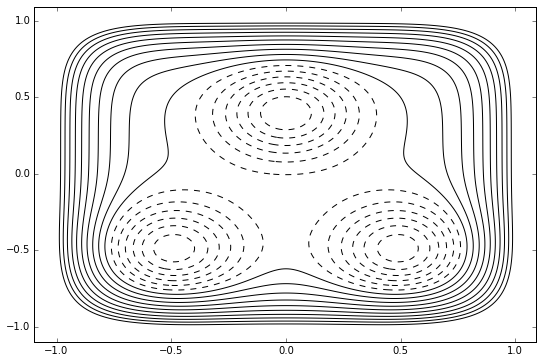

In [36]:
from toy_plot_helpers import ToyPlot
xval = paths.CV_Function("xval", lambda snap : snap.xyz[0][0])
yval = paths.CV_Function("yval", lambda snap : snap.xyz[0][1])
mstis_calc.live_visualization = paths.LiveVisualization(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(engine.pes)
mstis_calc.live_visualization.background = background.plot()
#mstis_calc.visualize_frequency = 25 # speeds things up, but isn't as pretty

Now everything is ready: let's run the simulation!

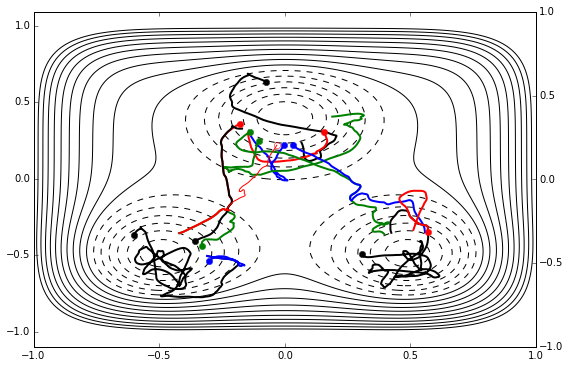

Working on Monte Carlo cycle number 30.



KeyboardInterrupt: 

In [37]:
mstis_calc.run_until(300)

In [38]:
storage.sync()

In [42]:
print repr(storage.pathmovechanges[0])

EmptyPathMoveChange (0x111da0050)


In [44]:
storage.pathmovechanges[10]

PathSimulatorPathMoveChange (0x11076b810)

In [1]:
import openpathsampling as p

In [2]:
st = p.storage.Storage('mstis.nc', mode='r')

In [5]:
st.pathmovers[0]